In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
%matplotlib inline
import GPy
import cvxpy

In [2]:
def gauss_gp(y, plot = False):
    """
    y: np n x 1 array of input data
    """   
    x = np.atleast_2d(np.linspace(0, y.shape[0] - 1, y.shape[0])).T
    
    # squared gaussian kernel
    kernel  = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

    # initialize gaussian process
    gp = GPy.models.GPRegression(x,y,kernel)
    
    # optimize gp
    gp.optimize()
  
    # point to predict at
    point = (x[-1] + 1).reshape(1, -1)
    
    # predict
    pred, sigma = gp.predict(point)
    
    return_frac = pred / y[-1] - 1
    
    # plotting
    if plot:
        plt.plot(list(y) + [pred])
    
    # return sharpe
    return return_frac[0,0], sigma

()


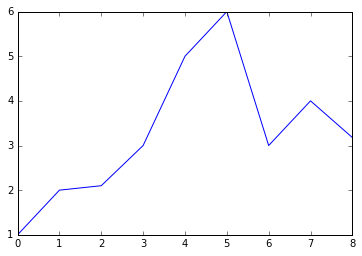

In [3]:
a = np.array([[1, 2, 2.1, 3, 5, 6,3 ,4]]).T
R, cov = gauss_gp(a, True)
print(R.shape)

In [4]:
def cov_return_sigma(X, sharpe_func):
    """
    X: n x k numpy array of stocks
    sharpe_func: function that takes an n x 1 array of input data and 
                 returns a tuple of return rate and std. deviation of 
                 that return rate
    """
    
    cov = np.cov(X)
    
    return_sigma = np.array([sharpe_func(X[i][:, np.newaxis]) for i in range(X.shape[0])])
    
    returns = return_sigma[:,0]
    sigma = return_sigma[:,1]
    
    return cov, returns, sigma
    

In [120]:
def read_stocks(dir_name, random = False, num_rand = None):
    """
    dir_name: string directory name
    
    returns: stocks as rows all concatenated to min. length
    
    Assumes stocks are csv's
    """
    stock_files = glob.glob(dir_name + '/*.csv')
    
    if random:
        ind = np.random.randint(0, len(stock_files), size = num_rand)
        stock_files = list(np.array(stock_files)[ind])
    
    labels = []
    
    X = []
    min_len = 100000
    
    for stock in stock_files:
        x = pd.read_csv(stock)['Adj Close'].as_matrix().astype(np.float64)
        if x.shape[0] >= 100:
            if x.shape[0] < min_len:
                min_len = x.shape[0]
            X.append(x)
            labels.append(stock[len(dir_name) + 1:][0:-4])
        
    for i in range(len(X)):
        X[i] = X[i][-min_len:]
        
    X = np.array(X)
    
    # lables
    return labels, X[:,0:-1], X[:,-1][:,np.newaxis]

In [110]:
def optimize_port(R, sigma, theta):
    """
    cor: Nxk correlation matrix of stocks
    returns: Nx1 return fraction matrix
    sigma: Nx1 expected standard deviation on returns
    """
    
    w = cvxpy.Variable(R.shape[0])
    
    objective = cvxpy.Minimize(-theta * R.T @ w + (1 - theta) * cvxpy.quad_form(w, sigma))
    
    ones = np.ones(R.shape[0])
    
    constraints = [w >= 0, sum(w) == 1]
    
    problem = cvxpy.Problem(objective, constraints)
    
    result = problem.solve()
    
    return (w.value)
    
    

In [113]:
labels, X, y = read_stocks('/home/nate/Courses/bigdata/bigdata_hw/final_project/stock_data2')

cov, returns, sigma = cov_return_sigma(X, gauss_gp) 

cov += 10 * np.diag(sigma)
    
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)


In [11]:
is_pos_def(cov)

True

In [114]:
opt = optimize_port(returns, cov, .5)

In [115]:
print(opt.shape)

l = np.array(labels)[:,np.newaxis]

choices = l[np.where(opt>.001)]

weights = opt[opt>.001]

weights /= np.sum(weights)

print(weights, choices)

(48, 1)
[[ 0.03144221  0.00553032  0.0353734   0.13879926  0.00245592  0.01147424
   0.00977938  0.05875406  0.01936416  0.51558835  0.0772557   0.01873162
   0.00162832  0.02449255  0.0122944   0.00434967  0.00251014  0.00272269
   0.02745363]] ['FINZ' 'FL' 'FGL' 'FHY' 'FIT' 'FIVN' 'FLIC' 'FITBI' 'FLAT' 'FHCO' 'FIG'
 'FISI' 'FINL' 'FLC' 'FGEN' 'FITB' 'FIX' 'FGP' 'FHN']


In [104]:
def return_frac(w, last_X, y):
    """
    w: weights of stocks
    X: original data
    y: back_test data
    """
    returns = (y / last_X - 1)[:,np.newaxis]
    return (w @ returns)[0,0]

In [116]:
l_X = X[:,-1][:,np.newaxis]
l_X = l_X[np.where(opt>.001)]
l_y = y[np.where(opt>.001)]

print(l_y.shape, l_X.shape)

return_frac(weights,l_X,l_y)

(19,) (19,)


-0.01208591044786152

In [122]:
def find_theta(returns, cov):
    """
    
    """
    bestVal = -10000
    bestTheta = 0

    for i in range(1,10):
        test = 1.0/i
        opt = optimize_port(returns, cov, test)

        weights = opt[opt>.001]
        weights /= np.sum(weights)

        l = np.array(labels)[:,np.newaxis]
        l_X = X[:,-1][:,np.newaxis]
        l_X = l_X[np.where(opt>.001)]
        l_y = y[np.where(opt>.001)]

        temp = return_frac(weights, l_X, l_y)
        if temp > bestVal:
            bestVal = temp
            bestTheta = 1./i    
        return bestVal, bestTheta, l_X

In [118]:
print(bestTheta, bestVal)

1.0 0.00228174544885


In [ ]:
def full_test(dir_name, num_stocks, num_tests):
    thetas = []
    returns_list = []
    for i in range(num_tests):
        labels, X, y = read_stocks('/home/nate/Courses/bigdata/bigdata_hw/final_project/stock_data2', random = True, num_rand=num_stocks)
        
        cov, returns, sigma = cov_return_sigma(X, gauss_gp) 
        bestVal, bestTheta, l_X = find_theta(returns, cov)
        
        thetas.append((bestVal, bestTheta))
        returns_list.append(return_frac())
        
        